In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_x2_var, get_x2_var_short_time
from functions import get_var_hist,simulate_traj, create_R, get_prop_abs, get_steady_mean, get_theo_var_l, get_non_delayed_prop, get_non_delayed_dyn
from functions import get_eq_times, SimulationManager, forces_dict
from setup import setup_matplotlib, one_col, std_height, two_col
from timeit import default_timer as timer

setup_matplotlib()

np.random.seed(42)

In [3]:
s = 1
D = s**2/2
max_t = 10
ntau = 3
# dx = 0.3
N_x = 21
eq_perc = 0.75
force = "linear"


f = 15
N_p = 2_000
N_loop = 10

ntau_sim = f*ntau

ltaus = np.concatenate(([0,0.05], np.arange(0.2,2.2,0.1) ))
sbs = np.empty(len(ltaus))
sim_vars = np.empty((len(ltaus),2))
sim_eq_time = np.empty((len(ltaus),2))

sim_hist_vars = np.empty((len(ltaus),2))
sim_hist_eq_time = np.empty((len(ltaus),2))

num_vars = np.empty((len(ltaus),2))
num_eq_time = np.empty((len(ltaus),2))

In [4]:
test_ltaus = np.arange(0, 1.5, 0.025)
exact_eqtimes = [get_eq_times(tau, D, 0.75) for tau in test_ltaus]

def get_99_time(ltau):
    return exact_eqtimes[np.argmin((ltau - test_ltaus)**2)]*np.log(0.01)/np.log(1-eq_perc) #last factor goes from to 0.99 of total var

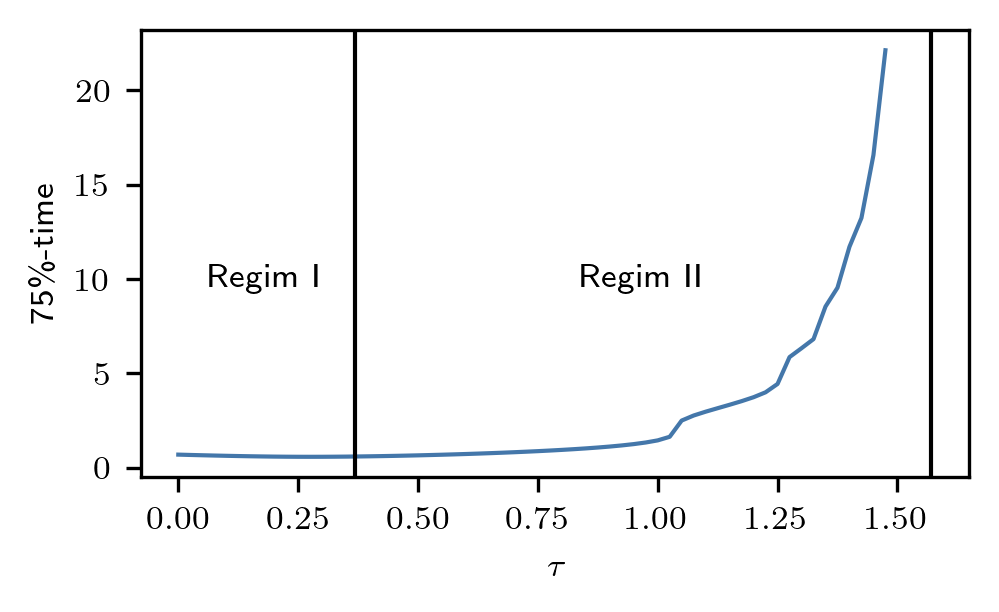

In [5]:
plt.plot(test_ltaus, exact_eqtimes, label='exact')
#plt.yscale('log')
plt.ylim(*plt.ylim())
plt.vlines([1/np.e, np.pi/2],*plt.ylim(), color='black')

y = 10
plt.text(0.5*1/np.e,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e+  np.pi/2),y,'Regim II',ha='center', va='center')
#plt.text(0.5*(np.pi/2/k + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')

#plt.legend()

plt.xlabel(r'$\tau$')
plt.ylabel(r'75\%-time')
plt.tight_layout()

In [6]:
my_sim_manager = SimulationManager()

for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau_sim if ltau > 0 else 0.01
    N_t = int(max_t/ldt)+1

    res = my_sim_manager.run(
        N_p=N_p,
        N_loop=N_loop,
        N_t=N_t,
        N_x=N_x,
        ntau=ntau_sim,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
        hist_sigma=3,
    )
    
    sim_ts = np.arange(0,(N_t+ntau_sim))*ldt-ltau

    sim_var = res['sim_var']
    sim_hist_var = res['sim_hist_var']
    sbs[i] = - res['x_s'][0]
    
    mean_sim_vars = np.mean(sim_var[:,-f*ntau*2:], axis = 1)
    sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))
    
    mean_s_eq = sim_ts[np.argmin((eq_perc*mean_sim_vars[:,None]-sim_var)**2, axis = 1)]
    sim_eq_time[i] = (np.mean(mean_s_eq), np.std(mean_s_eq)/np.sqrt(N_loop))
    
    mean_sim_hist_var = np.mean(sim_hist_var[:,-f*ntau*2:], axis = 1)
    sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))
    
    mean_sh_eq = sim_ts[np.argmin((eq_perc*mean_sim_hist_var[:,None]-sim_hist_var)**2, axis = 1)]
    sim_hist_eq_time[i] = (np.mean(mean_sh_eq), np.std(mean_sh_eq)/np.sqrt(N_loop))

  0%|          | 0/22 [00:00<?, ?it/s]

In [7]:
for i,ltau in enumerate(tqdm(ltaus)):
    ldt = ltau/ntau if ltau > 0 else 0.01
    N_t = int(max_t/ldt)+1
    
    ts = np.arange(0,N_t)*ldt

    sb = sbs[i]
    dx = 2*sb/(N_x-1)

    x_s = np.arange(-sb,sb+1e-6,dx)
    i_zero = np.argmin(x_s**2)

    if ltau > 0:
        # v1
        # prop = get_prop_abs(x_s, force,D,ldt,dx)
        # R, _, end_states = create_R(N_x, ntau, prop)

        # v2
        prop = get_prop_abs_v2(x_s, forces_dict[force],D,ldt,dx)
        R, _, end_states = create_R_v1(N_x, ntau, prop)

        _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
    else:
        R = get_non_delayed_prop(x_s, forces_dict[force],D,ldt,dx)
        hists = get_non_delayed_dyn(R,i_zero,N_t, N_x)
    
    num_var = get_var_hist(hists, x_s)

    mean_num_var = np.mean(num_var[-ntau*2:])
    num_vars[i] =  (mean_num_var, np.max(num_var[-ntau*2:])-np.min(num_var[-ntau*2:]))
    num_eq_time[i] =  ts[np.argmin((eq_perc*mean_num_var-num_var)**2)]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [10]:
short_time_approx_var = get_x2_var_short_time(ltaus, 1, s)
exact_sol = get_x2_var(ltaus, 1, s)

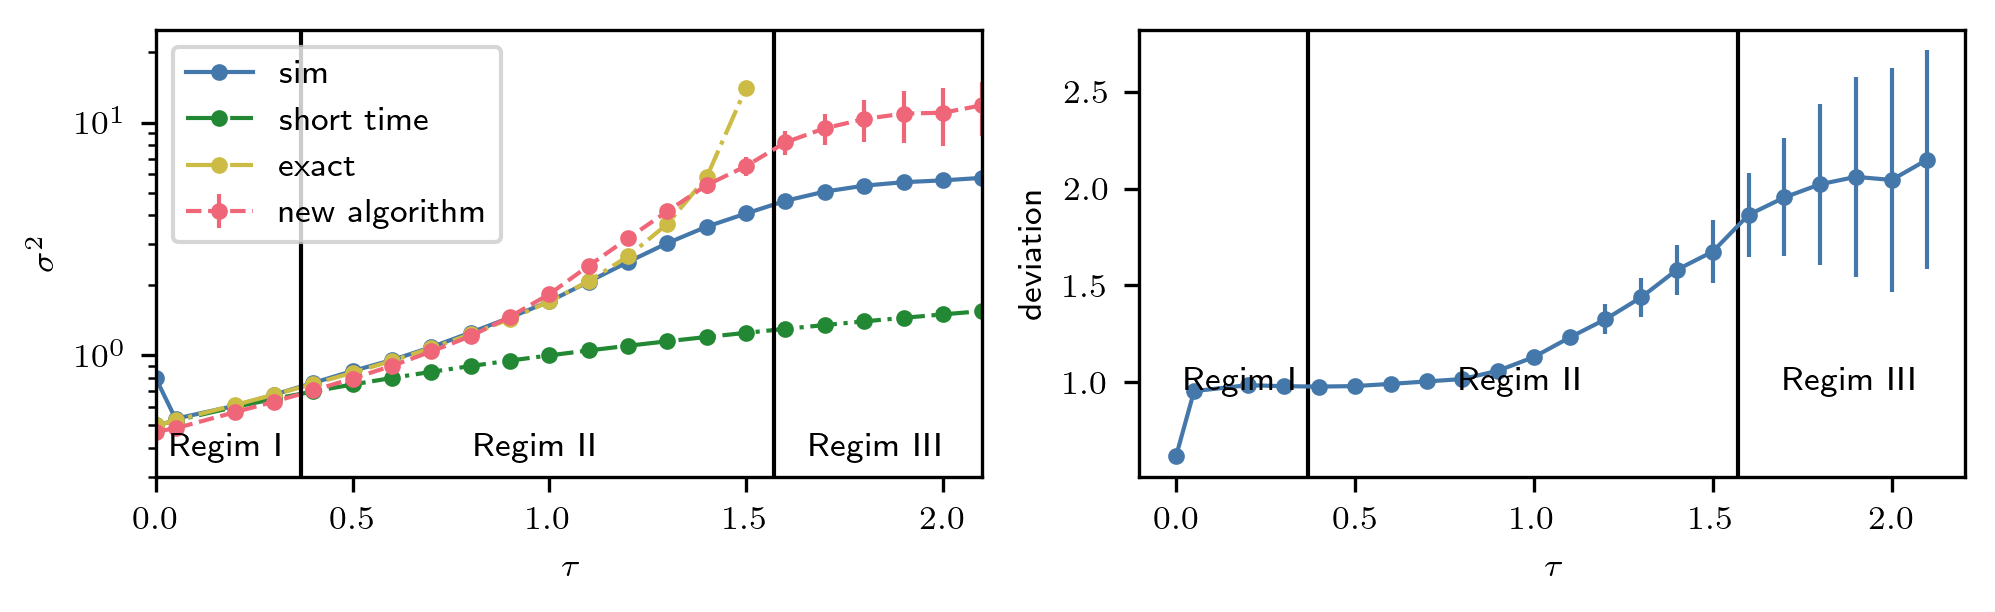

In [14]:
plt.figure(figsize=(two_col,std_height))
ax = plt.subplot(121)
plt.plot(ltaus,sim_vars[:,0],'.-', label='sim')
plt.errorbar(ltaus,num_vars[:,0],num_vars[:,1],marker='.', ls='--', label='new algorithm')
plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')
plt.plot(ltaus[ltaus < np.pi/2],exact_sol[ltaus < np.pi/2] ,'.-.',label='exact')
# plt.errorbar(ltaus,sim_hist_vars[:,0],sim_hist_vars[:,1],marker='.', label='hist-sim')
plt.ylim(3e-1,25)
plt.xlim(0,2.1)
plt.vlines([1/np.e, np.pi/2],*plt.ylim(), color='black')
y = 4e-1
plt.text(0.5*1/np.e,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e+  np.pi/2),y,'Regim II',ha='center', va='center')
plt.text(0.5*(np.pi/2 + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')

plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')

#auflösungslimit
#plt.hlines((x_s[-1]/3)**2, *plt.xlim())

ax = plt.subplot(122)
plt.errorbar(ltaus, num_vars[:,0]/sim_hist_vars[:,0], 
             yerr = np.sqrt( ( num_vars[:,1]/sim_hist_vars[:,0])**2 + (num_vars[:,0]/sim_hist_vars[:,0]**2*sim_hist_vars[:,1])**2),
                            marker = '.')
plt.ylim(*plt.ylim())
plt.vlines([1/np.e, np.pi/2],*plt.ylim(), color='black')
y = 1
plt.text(0.5*1/np.e,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e+  np.pi/2),y,'Regim II',ha='center', va='center')
plt.text(0.5*(np.pi/2 + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')
#plt.plot(ltaus, num_vars[:,0]/sim_vars[:,0], '.-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'deviation')


plt.tight_layout()
#plt.savefig(f'graphics/x2variance_v2_Nx{N_x}_ntau{ntau}.pdf')

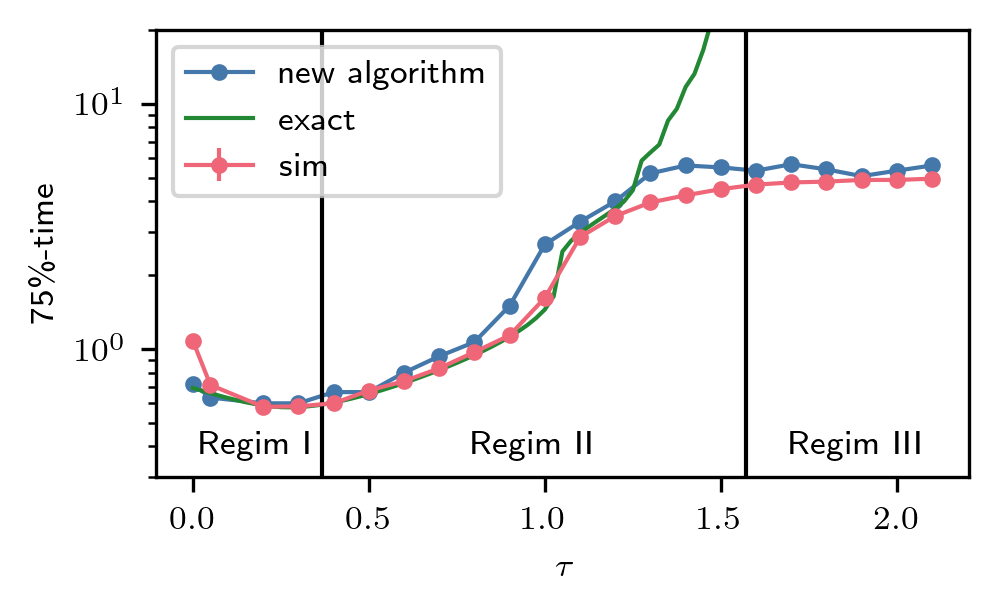

In [17]:
plt.plot(ltaus, num_eq_time[:,0], marker ='.', label = 'new algorithm')
#plt.errorbar(ltaus, *sim_hist_eq_time.T, marker ='.', label = 'hist-sim')
plt.errorbar(ltaus, *sim_eq_time.T, marker ='.', label = 'sim')

plt.plot(test_ltaus, exact_eqtimes, label='exact')


plt.ylim(3e-1,2e1)
plt.vlines([1/np.e, np.pi/2],*plt.ylim(), color='black')

y = 4e-1
plt.text(0.5*1/np.e,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e+  np.pi/2),y,'Regim II',ha='center', va='center')
plt.text(0.5*(np.pi/2 + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')

plt.legend()
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'75\%-time')
plt.tight_layout()
#plt.savefig(f'graphics/x2eqtime_v2_Nx{N_x}_ntau{ntau}.pdf')